In [0]:
import numpy as np

from keras.models import Model
from keras.layers import Dense, Embedding, Input, Dropout, Lambda, Flatten
from keras.layers import Dot, Activation, Softmax, Add, Multiply, Permute
from keras.layers import dot, add, multiply

from keras.engine.topology import Layer

from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences

# from src.util import *

from keras.backend import variable, transpose, reshape, gather
from keras import backend as K


import tarfile
from functools import reduce
import numpy as np
import re

Using TensorFlow backend.


In [0]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))


In [0]:
# from google.colab import files
# files.upload()

In [0]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise


challenges = {
    # QA1 with 10,000 samples
    'qa1': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    'qa2': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
    'qa3': 'tasks_1-20_v1-2/en-10k/qa3_three-supporting-facts_{}.txt',
    'qa4': 'tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_{}.txt',
    'qa5': 'tasks_1-20_v1-2/en-10k/qa5_three-arg-relations_{}.txt',
    'qa6': 'tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_{}.txt',
    'qa7': 'tasks_1-20_v1-2/en-10k/qa7_counting_{}.txt',
    'qa8': 'tasks_1-20_v1-2/en-10k/qa8_lists-sets_{}.txt',
    'qa9': 'tasks_1-20_v1-2/en-10k/qa9_simple-negation_{}.txt',
    'qa10': 'tasks_1-20_v1-2/en-10k/qa10_indefinite-knowledge_{}.txt',
    'qa11': 'tasks_1-20_v1-2/en-10k/qa11_basic-coreference_{}.txt',
    'qa12': 'tasks_1-20_v1-2/en-10k/qa12_conjunction_{}.txt',
    'qa13': 'tasks_1-20_v1-2/en-10k/qa13_compound-coreference_{}.txt',
    'qa14': 'tasks_1-20_v1-2/en-10k/qa14_time-reasoning_{}.txt',
    'qa15': 'tasks_1-20_v1-2/en-10k/qa15_basic-deduction_{}.txt',
    'qa16': 'tasks_1-20_v1-2/en-10k/qa16_basic-induction_{}.txt',
    'qa17': 'tasks_1-20_v1-2/en-10k/qa17_positional-reasoning_{}.txt',
    'qa18': 'tasks_1-20_v1-2/en-10k/qa18_size-reasoning_{}.txt',
    'qa19': 'tasks_1-20_v1-2/en-10k/qa19_path-finding_{}.txt',
    'qa20': 'tasks_1-20_v1-2/en-10k/qa20_agents-motivations_{}.txt',
}

challenge_type = 'qa{}'

11747328/11745123 [==============================] - 1s 0us/step


In [0]:
class MemN2NBlock(Layer): 
    def __init__(self, output_dim):
        super(MemN2NBlock, self).__init__()
        
        self.output_dim = output_dim
        
        # layer operations
        self.input_memory = Dot(axes=(-1))
        self.input_representation = Softmax()
        self.permute_weights = Permute((2,1))
        self.output_memory = Dot(axes=(2,1))
        self.h_mapping = self.add_weight(
                name='H',
                shape=(self.output_dim[2],output_dim[2]),
                initializer='glorot_normal',
                trainable=True
        )
        self.new_u = Add()
        
    def call(self, inputs):
        m = self.input_memory([inputs[0], inputs[1]])
        p = self.input_representation(m)
        # print('p.shape: ', p.shape)
        # p = self.permute_weights(p) 
        p = reshape(p, [-1, p.shape[2], p.shape[1]])
        # print('p.shape: ', p.shape)
        c = self.output_memory([p, inputs[2]])
        
        mapped_u = K.dot(inputs[1], self.h_mapping)
        
        return self.new_u([c, mapped_u])
        
    def build(self, input_shape):
        super(MemN2NBlock, self).build(input_shape)
        
    def compute_output_shape(self, input_shape):
        return self.output_dim
 

In [0]:
def build_model(story_maxlen, query_maxlen, vocab_size):
    print('MEM N2N model')

    HOPS = 3

    sentences = Input((story_maxlen,))
    question = Input((query_maxlen,))

    A = Embedding(vocab_size, 64, na)(sentences)
    B = Embedding(vocab_size, 64)(question)
    C = Embedding(vocab_size, 64)(sentences)

    u = B
    u_shape = tuple(map(lambda x: x.value, u.shape))

    for i in range(HOPS):
        u = MemN2NBlock(output_dim=u_shape)([A, u, C])

    # u = Lambda(lambda x: K.sum(x, axis=1))(u) 
    u = Flatten()(u)

    result = Dense(vocab_size, activation='softmax', use_bias=False)(u)

    print(result.shape)


    MemN2Nmodel = Model(inputs=[sentences, question], outputs=result)
    MemN2Nmodel.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return MemN2Nmodel

In [0]:
# Tasks 1 to 5

histories = []
for i in range(1, 6):
    challenge = challenges[challenge_type.format(i)]
  
    print('Extracting stories for the challenge:', challenge_type.format(i))
    print(challenge.format(''))
  
    with tarfile.open(path) as tar:
        train_stories = get_stories(tar.extractfile(challenge.format('train')))
        test_stories = get_stories(tar.extractfile(challenge.format('test')))

    # Building vocabulary
    vocab = set()
    for story, q, answer in train_stories + test_stories:
        vocab |= set(story + q + [answer])
    vocab = sorted(vocab)

    # Reserve 0 for masking via pad_sequences
    vocab_size = len(vocab) + 1
    story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
    query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

    word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
    inputs_train, queries_train, answers_train = vectorize_stories(train_stories, word_idx, story_maxlen, query_maxlen)
    inputs_test, queries_test, answers_test = vectorize_stories(test_stories, word_idx, story_maxlen, query_maxlen)

    model = build_model(story_maxlen, query_maxlen, vocab_size)

    history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=150,
          validation_data=([inputs_test, queries_test], answers_test))

    histories.append(history)


Extracting stories for the challenge: qa1
tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_.txt


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


MEM N2N model
Instructions for updating:
Colocations handled automatically by placer.
(?, 22)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/150
10000/10000 [==============================] - 5s 459us/step - loss: 1.6062 - acc: 0.3394 - val_loss: 1.3943 - val_acc: 0.4610
Epoch 2/150
10000/10000 [==============================] - 2s 171us/step - loss: 1.3403 - acc: 0.4721 - val_loss: 1.3313 - val_acc: 0.4710
Epoch 3/150
10000/10000 [==============================] - 2s 155us/step - loss: 1.2867 - acc: 0.5004 - val_loss: 1.3515 - val_acc: 0.4780
Epoch 4/150
10000/10000 [==============================] - 1s 146us/step - loss: 1.2651 - acc: 0.4994 - val_loss: 1.2999 - val_acc: 0.4820
Epoch 5/150
10000/10000 [==============================] - 1s 147us/step - loss: 1.2473 - acc: 0.5058 - val_loss: 1.3191 - val_acc: 0.4860
Epoch 6/150
10000/10000 [===========

In [0]:
# Tasks 6 to 10

for i in range(6, 11):
    challenge = challenges[challenge_type.format(i)]
  
    print('Extracting stories for the challenge:', challenge_type.format(i))
    print(challenge.format(''))
  
    with tarfile.open(path) as tar:
        train_stories = get_stories(tar.extractfile(challenge.format('train')))
        test_stories = get_stories(tar.extractfile(challenge.format('test')))

    # Building vocabulary
    vocab = set()
    for story, q, answer in train_stories + test_stories:
        vocab |= set(story + q + [answer])
    vocab = sorted(vocab)

    # Reserve 0 for masking via pad_sequences
    vocab_size = len(vocab) + 1
    story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
    query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

    word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
    inputs_train, queries_train, answers_train = vectorize_stories(train_stories, word_idx, story_maxlen, query_maxlen)
    inputs_test, queries_test, answers_test = vectorize_stories(test_stories, word_idx, story_maxlen, query_maxlen)

    model = build_model(story_maxlen, query_maxlen, vocab_size)

    history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=150,
          validation_data=([inputs_test, queries_test], answers_test))

    histories.append(history)

Extracting stories for the challenge: qa6
tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_.txt


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


MEM N2N model
(?, 38)
Train on 10000 samples, validate on 1000 samples
Epoch 1/150
10000/10000 [==============================] - 2s 210us/step - loss: 0.7483 - acc: 0.4850 - val_loss: 0.6958 - val_acc: 0.4570
Epoch 2/150
10000/10000 [==============================] - 1s 146us/step - loss: 0.6877 - acc: 0.5319 - val_loss: 0.6645 - val_acc: 0.5990
Epoch 3/150
10000/10000 [==============================] - 2s 152us/step - loss: 0.6246 - acc: 0.6530 - val_loss: 0.6006 - val_acc: 0.6910
Epoch 4/150
10000/10000 [==============================] - 1s 146us/step - loss: 0.5758 - acc: 0.7011 - val_loss: 0.5966 - val_acc: 0.7080
Epoch 5/150
10000/10000 [==============================] - 1s 147us/step - loss: 0.5669 - acc: 0.7169 - val_loss: 0.6015 - val_acc: 0.6990
Epoch 6/150
10000/10000 [==============================] - 1s 149us/step - loss: 0.5581 - acc: 0.7230 - val_loss: 0.5988 - val_acc: 0.6790
Epoch 7/150
10000/10000 [==============================] - 1s 146us/step - loss: 0.5483 - acc: 

In [0]:
# Tasks 11 to 15

for i in range(11, 16):
    challenge = challenges[challenge_type.format(i)]
  
    print('Extracting stories for the challenge:', challenge_type.format(i))
    print(challenge.format(''))
  
    with tarfile.open(path) as tar:
        train_stories = get_stories(tar.extractfile(challenge.format('train')))
        test_stories = get_stories(tar.extractfile(challenge.format('test')))

    # Building vocabulary
    vocab = set()
    for story, q, answer in train_stories + test_stories:
        vocab |= set(story + q + [answer])
    vocab = sorted(vocab)

    # Reserve 0 for masking via pad_sequences
    vocab_size = len(vocab) + 1
    story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
    query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

    word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
    inputs_train, queries_train, answers_train = vectorize_stories(train_stories, word_idx, story_maxlen, query_maxlen)
    inputs_test, queries_test, answers_test = vectorize_stories(test_stories, word_idx, story_maxlen, query_maxlen)

    model = build_model(story_maxlen, query_maxlen, vocab_size)

    history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=150,
          validation_data=([inputs_test, queries_test], answers_test))

    histories.append(history)

Extracting stories for the challenge: qa11
tasks_1-20_v1-2/en-10k/qa11_basic-coreference_.txt


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


MEM N2N model
(?, 29)
Train on 10000 samples, validate on 1000 samples
Epoch 1/150
10000/10000 [==============================] - 2s 245us/step - loss: 1.5419 - acc: 0.3817 - val_loss: 1.0735 - val_acc: 0.6490
Epoch 2/150
10000/10000 [==============================] - 1s 146us/step - loss: 1.0106 - acc: 0.6582 - val_loss: 0.8752 - val_acc: 0.7160
Epoch 3/150
10000/10000 [==============================] - 1s 148us/step - loss: 0.9096 - acc: 0.6778 - val_loss: 0.8903 - val_acc: 0.7000
Epoch 4/150
10000/10000 [==============================] - 1s 147us/step - loss: 0.8788 - acc: 0.6802 - val_loss: 0.8232 - val_acc: 0.7130
Epoch 5/150
10000/10000 [==============================] - 1s 148us/step - loss: 0.8538 - acc: 0.6829 - val_loss: 0.8202 - val_acc: 0.7100
Epoch 6/150
10000/10000 [==============================] - 1s 147us/step - loss: 0.8354 - acc: 0.6882 - val_loss: 0.8096 - val_acc: 0.7110
Epoch 7/150
10000/10000 [==============================] - 1s 148us/step - loss: 0.8173 - acc: 

In [0]:
# Tasks 16 to 20

for i in range(16, 21):
    challenge = challenges[challenge_type.format(i)]
  
    print('Extracting stories for the challenge:', challenge_type.format(i))
    print(challenge.format(''))
  
    with tarfile.open(path) as tar:
        train_stories = get_stories(tar.extractfile(challenge.format('train')))
        test_stories = get_stories(tar.extractfile(challenge.format('test')))

    # Building vocabulary
    vocab = set()
    for story, q, answer in train_stories + test_stories:
        vocab |= set(story + q + [answer])
    vocab = sorted(vocab)

    # Reserve 0 for masking via pad_sequences
    vocab_size = len(vocab) + 1
    story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
    query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

    word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
    inputs_train, queries_train, answers_train = vectorize_stories(train_stories, word_idx, story_maxlen, query_maxlen)
    inputs_test, queries_test, answers_test = vectorize_stories(test_stories, word_idx, story_maxlen, query_maxlen)

    model = build_model(story_maxlen, query_maxlen, vocab_size)

    history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=150,
          validation_data=([inputs_test, queries_test], answers_test))

    histories.append(history)

Extracting stories for the challenge: qa16
tasks_1-20_v1-2/en-10k/qa16_basic-induction_.txt


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


MEM N2N model
(?, 20)
Train on 10000 samples, validate on 1000 samples
Epoch 1/150
10000/10000 [==============================] - 3s 319us/step - loss: 1.1795 - acc: 0.4401 - val_loss: 1.1022 - val_acc: 0.4860
Epoch 2/150
10000/10000 [==============================] - 2s 155us/step - loss: 1.0944 - acc: 0.4706 - val_loss: 1.1015 - val_acc: 0.4900
Epoch 3/150
10000/10000 [==============================] - 2s 153us/step - loss: 1.0900 - acc: 0.4674 - val_loss: 1.0686 - val_acc: 0.4870
Epoch 4/150
10000/10000 [==============================] - 2s 152us/step - loss: 1.0862 - acc: 0.4742 - val_loss: 1.0644 - val_acc: 0.5000
Epoch 5/150
10000/10000 [==============================] - 2s 159us/step - loss: 1.0830 - acc: 0.4706 - val_loss: 1.0877 - val_acc: 0.4840
Epoch 6/150
10000/10000 [==============================] - 2s 154us/step - loss: 1.0828 - acc: 0.4751 - val_loss: 1.0641 - val_acc: 0.4850
Epoch 7/150
10000/10000 [==============================] - 2s 157us/step - loss: 1.0822 - acc: 

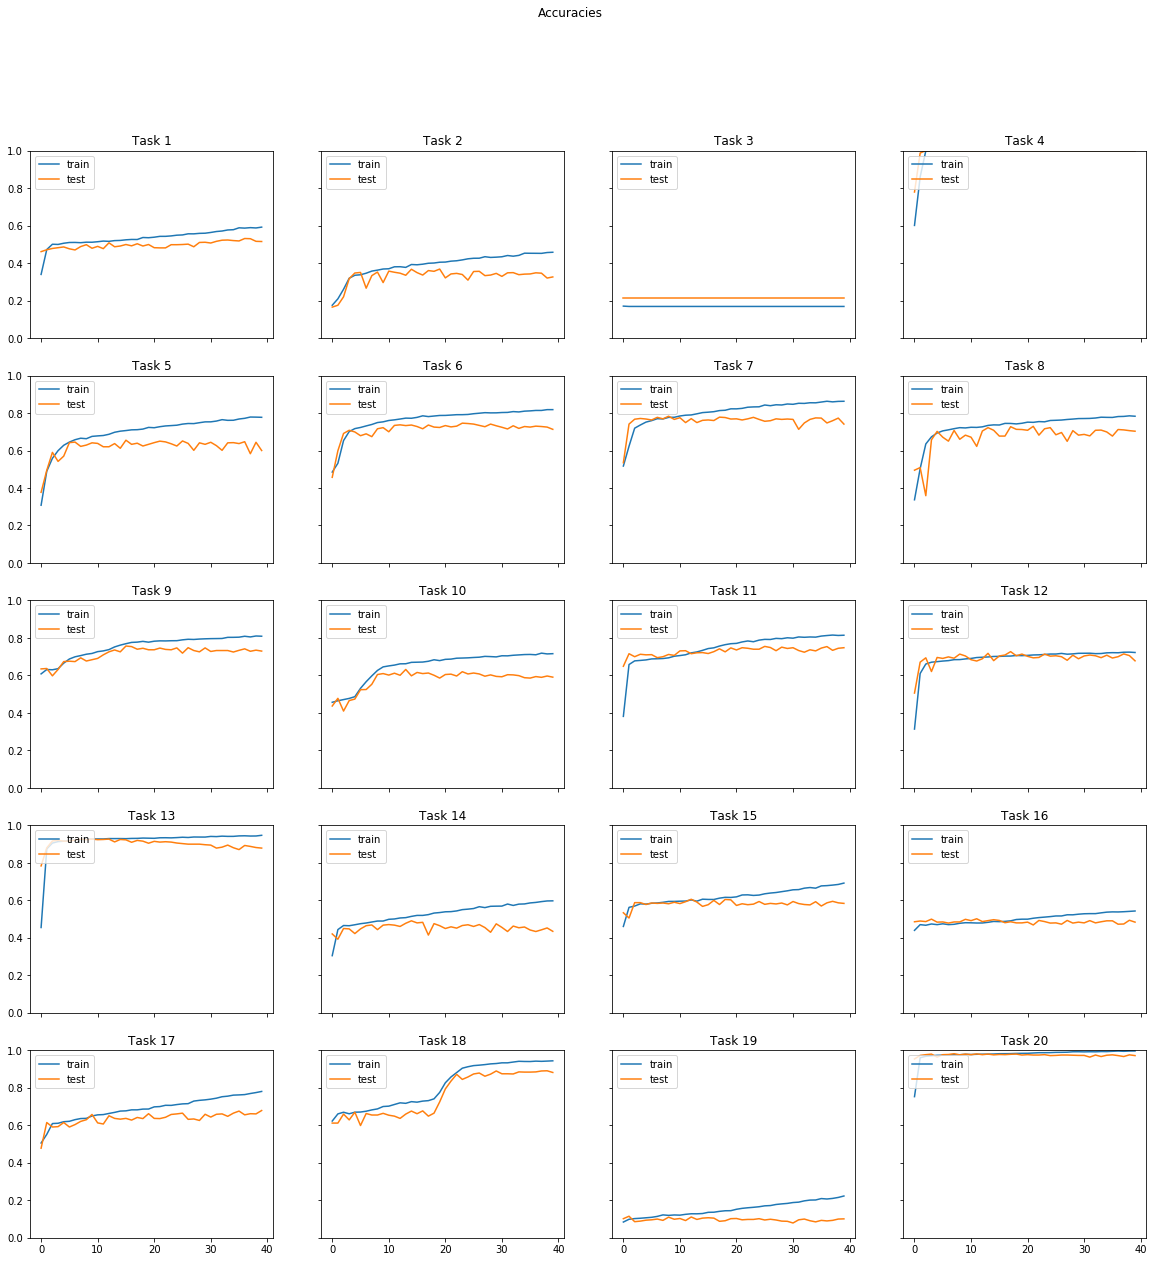

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, sharex='col', sharey='row')
fig.suptitle('Accuracies')
count = 0
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(5):
    for j in range(4):
    
        cur_ax = ax[i, j]

        cur_ax.set_ylim([0, 1])

        cur_ax.figsize = (10,10)
        cur_ax.plot(histories[count].history['acc'][:40])
        cur_ax.plot(histories[count].history['val_acc'][:40])
        cur_ax.set_title('Task {}'.format(count + 1))
        cur_ax.legend(['train', 'test'], loc='upper left')
        count += 1

fig.savefig('accuracies.png')

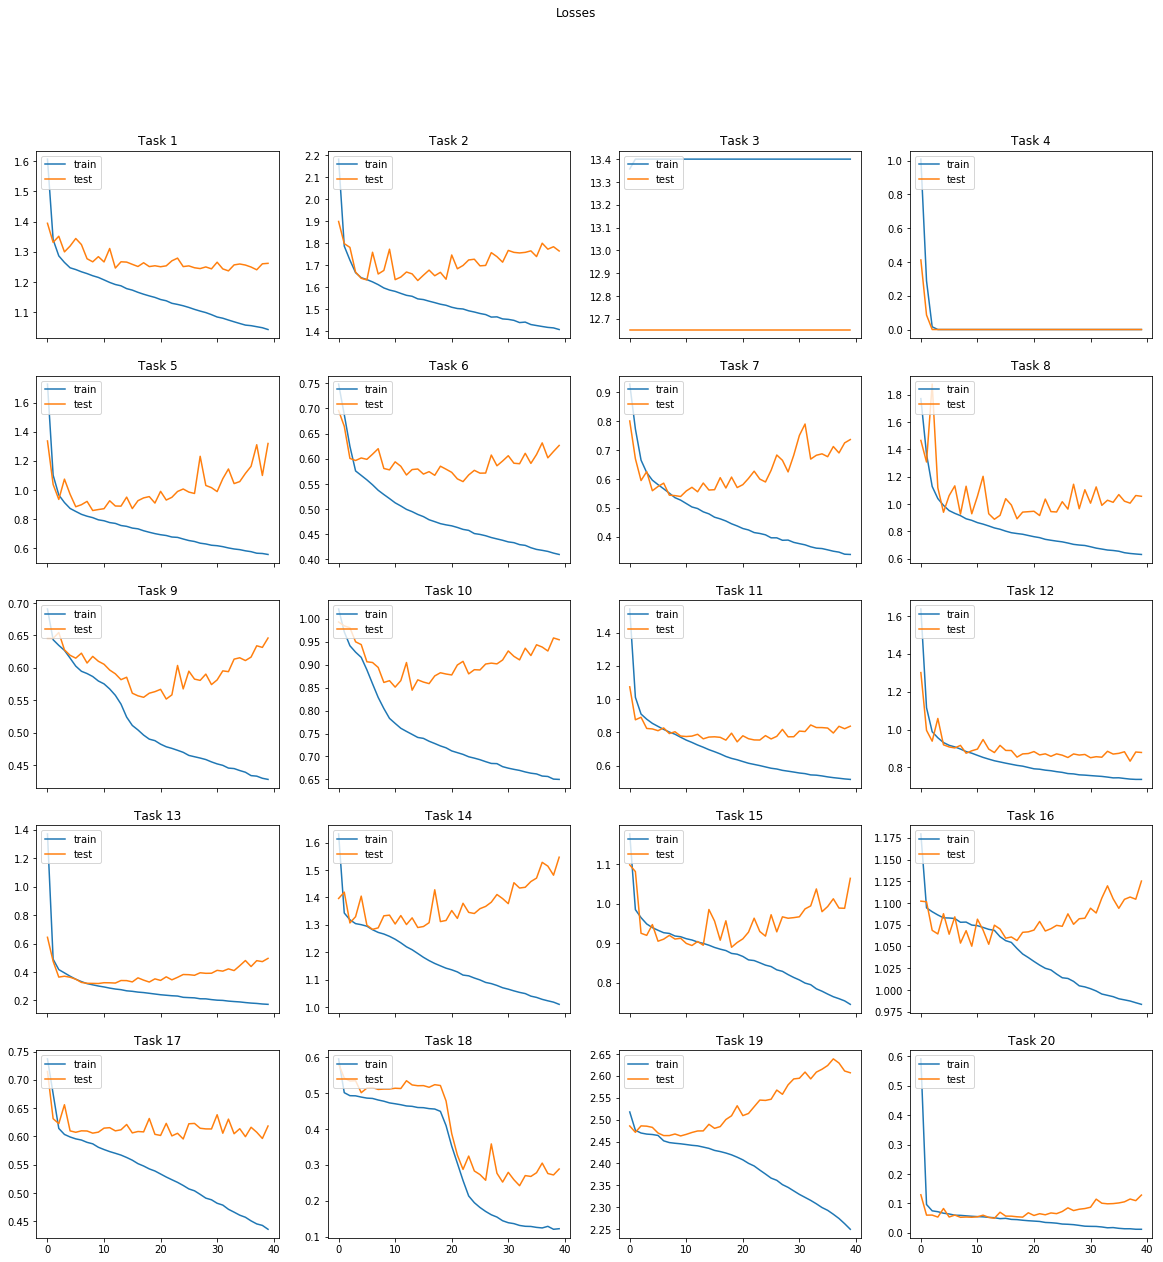

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, sharex='col', sharey='none')
fig.suptitle('Losses')
count = 0
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(5):
    for j in range(4):

        cur_ax = ax[i, j]

        cur_ax.figsize = (10,10)
        cur_ax.plot(histories[count].history['loss'][:40])
        cur_ax.plot(histories[count].history['val_loss'][:40])
        cur_ax.set_title('Task {}'.format(count + 1))
        cur_ax.legend(['train', 'test'], loc='upper left')
        count += 1

fig.savefig('losses.png')

In [0]:
from google.colab import files
files.download('accuracies.png')
files.download('losses.png')

In [0]:
histories[9].history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

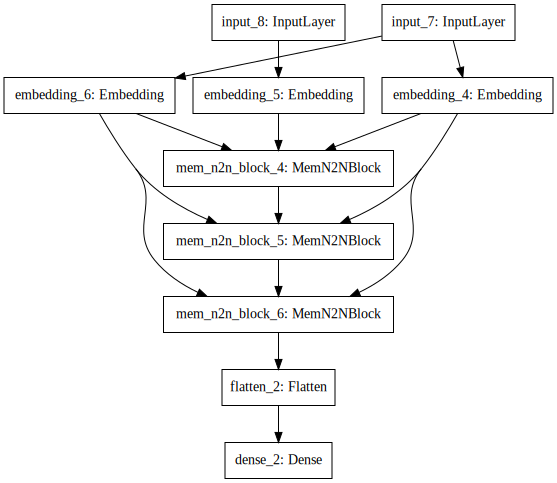

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(MemN2Nmodel).create(prog='dot', format='svg'))

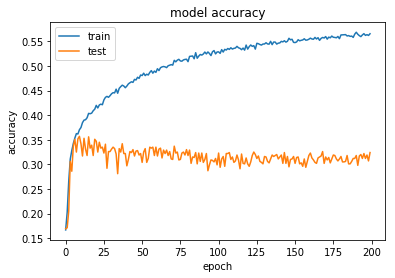

In [0]:
model = MemN2Nmodel
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(model.history.history['acc'][:200])
plt.plot(model.history.history['val_acc'][:200])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

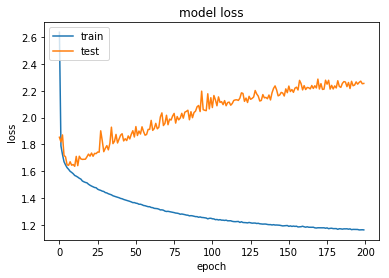

In [0]:
model = MemN2Nmodel
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(model.history.history['loss'][:200])
plt.plot(model.history.history['val_loss'][:200])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
